# Example `KBackground.Estimator` workflow with K2 Campaign 8

In this notebook we show how to use the `KBackground` tool to estimate rolling band. You can see a video of the rolling band in this dataset [here](https://www.youtube.com/watch?v=cAc70ErIsSQ).

In [1]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
from kbackground import Estimator
from astropy.io import fits
from astropy.table import Table

First we are going to get a number of the TPFs in a large superstamp in campaign 8. This will let us see a patch of data with a rolling band.

In [2]:
tpfs = []
for idx in np.arange(656, 656 + 26):
    tpfs.append(lk.search_targetpixelfile(f"EPIC 200068{idx}", mission='k2').download())

Next we will extract the row, column and flux values from all the TPFs.

In [3]:
rows, columns, fluxs, cadencenos = [], [], [], []
for tpf in tpfs:
    column, row = np.meshgrid(np.arange(tpf.column, tpf.shape[2] + tpf.column), np.arange(tpf.row, tpf.shape[1] + tpf.row))
    aper = np.ones(tpf.shape[1:], bool)
    rows.append(row[aper])
    columns.append(column[aper])
    fluxs.append(tpf.flux.value[:, aper])
    cadencenos.append(tpf.cadenceno)

Next we can build the `Estimator` object, passing in the row, column, and flux values from all the TPFs.

In [4]:
e = Estimator(cadencenos[0], np.hstack(rows), np.hstack(columns), np.hstack(fluxs))

Under the hood, `KBackground` works on the median subtracted frames, below we plot a median subtracted frame which shows a rolling band.

Text(0, 0.5, 'Row')

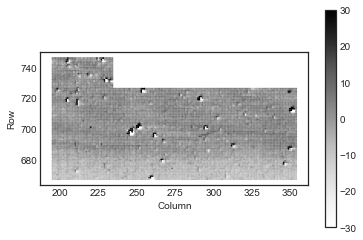

In [5]:
plt.scatter(np.hstack(columns), np.hstack(rows), s=1, c=e.flux[870] - np.median(e.flux, axis=0)[None, :], vmin=-30, vmax=30)
plt.gca().set_aspect('equal')
plt.colorbar()
plt.xlabel('Column')
plt.ylabel('Row')

We can access the model for any frame using

In [6]:
e.model

array([[1.28712773, 1.28712773, 1.28712773, ..., 2.32155258, 2.32155258,
        2.32155258],
       [1.35290325, 1.35290325, 1.35290325, ..., 2.04700656, 2.04700656,
        2.04700656],
       [1.40344498, 1.40344498, 1.40344498, ..., 1.82436255, 1.82436255,
        1.82436255],
       ...,
       [2.77369856, 2.77369856, 2.77369856, ..., 4.3147957 , 4.3147957 ,
        4.3147957 ],
       [2.69414027, 2.69414027, 2.69414027, ..., 4.50100538, 4.50100538,
        4.50100538],
       [3.58576972, 3.58576972, 3.58576972, ..., 4.56596829, 4.56596829,
        4.56596829]])

This is an attribute we can index into to get a particular time-series

In [7]:
e.model[:, 1000]

array([1.24713077, 1.30726434, 1.35558357, ..., 3.31622763, 3.15105023,
       3.80438955])

We can plot the model for the same frame above.

[Text(0.5, 1.0, 'Model'), Text(0.5, 0, 'Column'), Text(0, 0.5, 'Row')]

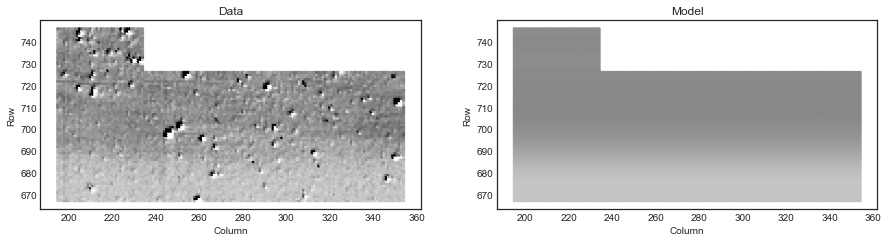

In [9]:
tdx = 890
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].scatter(np.hstack(columns), np.hstack(rows), s=5, c=e.flux[tdx] - np.median(e.flux, axis=0)[None, :], vmin=-30, vmax=30)
ax[0].set_aspect('equal')
ax[0].set(title='Data', xlabel='Column', ylabel='Row')
ax[1].scatter(np.hstack(columns), np.hstack(rows), s=5, c=e.model[tdx], vmin=-30, vmax=30)
ax[1].set_aspect('equal')
ax[1].set(title='Model', xlabel='Column', ylabel='Row')

Text(0, 0.5, 'Flux [counts]')

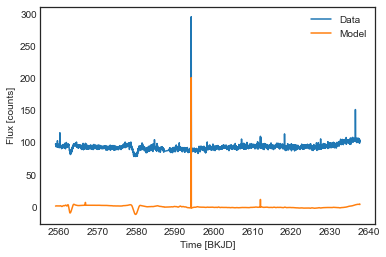

In [11]:
plt.plot(tpf.time.value, e.flux[:, 5060], label='Data')
plt.plot(tpf.time.value, e.model[:, 5060], label='Model')
plt.legend()
plt.xlabel('Time [BKJD]')
plt.ylabel('Flux [counts]')